In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sqlite3

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# NLTK
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
lmtz = WordNetLemmatizer()


def lemmatize(word):
    if word.startswith('#'):
        return word
    
    lemma = lmtz.lemmatize(word, 'v')
    if lemma == word:
        lemma = lmtz.lemmatize(word, 'n')
    return lemma


def strip_punc(s):
    if s[0] == '#' or s[0] == '@':
        return s
    return ''.join([c for c in s if c.isalpha()])

### Stop words

In [3]:
stop_words = [strip_punc(w) for w in stopwords.words('english')]
stop_words.extend([
    'i',
    'u',
    'r',
    'im',
    'cant',
    'would',
    'family',
    'domestic',
    'violence',
    'australia',
    'australian',
    'dv',
    'fv',
    'wa',
    'via',
    'today',
    'thing',
    'make',
    'talk',
    'due',
    'day',
    'month',
    'find',
    'show',
    'put',
    'part',
    'time',
    'yeah',
    'deal',
    'big',
    'level',
    'focus',
    'theyre',
    'list',
    'top',
    'give',
    'situation',
    'lot',
    'hold',
    'number',
    'include',
    'form',
    'back',
    'involve',
    'link',
    'real'
])

### Data from SQLite

In [4]:
conn = sqlite3.connect('dpc.db')
c = conn.cursor()

year = 2016

data = []
replied_ids = []
for (date, text, ftext, replied_id) in c.execute('SELECT created_at, text, [extended_tweet.full_text], in_reply_to_status_id FROM tweets'):
    if date.split(' ')[-1] == str(year):
        if ftext:
            data.append(ftext)
        else:
            data.append(text)
        
        if replied_id:
            replied_ids.append(replied_id)
        else:
            replied_ids.append(None)
        
conn.close()
print(len(data))
len(replied_ids)

26039


26039

### Preprocessing

In [5]:
set_cleaned_sent = set()
data_lemmatized = []
data_filtered = []
indices = [] # points back to index in original data

for i, sent in enumerate(data):
    
    cleaned_sent = ''
    for token in sent.split():
        
        # Cleaning
        if token[0] in ['@','$','%','^','&','*'] or token.startswith('http'):
            continue

        # Remove puctuations, lower case
        token = strip_punc(token.lower())
        
        # Lemmatize
        lemma = lemmatize(token)

        if lemma and lemma not in stop_words:
            cleaned_sent += lemma + ' '
    
    cleaned_sent = cleaned_sent.strip()
    
    # Check for duplicates
    if cleaned_sent and cleaned_sent not in set_cleaned_sent:
        set_cleaned_sent.add(cleaned_sent)
        data_lemmatized.append(cleaned_sent.split())
        data_filtered.append(sent)
        indices.append(i)
        
    if i % 100 == 0:
        print(i, end=' ')

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 18

In [ ]:
len(data_lemmatized)

In [ ]:
for i, sent in enumerate(data_lemmatized[:50]):
    print(indices[i], sent)

### Creating Bigram and Trigram Models

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_lemmatized, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_lemmatized], threshold=100)  

# Faster way to get a Tweet clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [7]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [8]:
data_lemmatized = make_bigrams(data_lemmatized)

### Create the Dictionary and Corpus needed for Topic Modeling

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(data_lemmatized[:1])

[['say']]


In [ ]:
len(id2word)

### Building LDA Mallet Model
Mallet’s version of LDA often gives a better quality of topics.
Num of topics = 20 at this step.

In [12]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

### Optimal number of topics for LDA
Build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

In [10]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        print(str(len(model_list)-1)+'-'+str(num_topics),end=' ')
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#### Topic coherence provide a convenient measure to judge how good a given topic model is.

In [13]:
# Takes a long time to run.
start = 8
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=8, limit=11, step=1)

0-8 1-9 2-10 

In [37]:
model = model_list[0]

#from scipy.spatial.distance import cosine

# Find the most representative document for each topic

In [14]:
# Finding the dominant topic in each Tweet


def format_topics_sentences(ldamodel, corpus=corpus, texts=data_filtered):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [38]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=data_filtered)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



### Compute dominant topic for each Tweet

In [39]:
# Group top 40 Tweets under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(10)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# # Format
# sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
len(sent_topics_sorteddf_mallet)

80

In [ ]:
sent_topics_sorteddf_mallet.head()

In [29]:
# 2014
#topic_names = ['Action needed','Legal action',"Men's actions",'Advocacy & campaigning','Government action','Violence justified','Service','Abuse experiences','Social causes','Culture of Violence']
# 2015
#topic_names = ['Culture & attitudes','Government action','Services needed',"Men's actions",'Advocacy & campaigning','Policing','Prevalence']
#2016
#topic_names = ['Violence & policing','Male perpetrators','Government inaction','Community support','Law reform','Successful programs','Social determinants',"Victims' Experiences"]
#2017
#topic_names = ['Social context','Male perpetrators','Survival and Inspiration','Prevalence & risk','Programs & services','Men as victims']
#2018
#topic_names = ['Gun violence','Prevalence',"Men's actions",'Contexts & causes','Prevention Strategy','Government inaction','Abuse experiences','Advocacy & Campaigning','Politics & Governance']

In [30]:
df = pd.DataFrame(columns=['Key','Doc_Id'])

for i, row in sent_topics_sorteddf_mallet.iterrows():
        topic_i = int(row['Dominant_Topic'])
        df.loc[i] = [str(year)+topic_names[topic_i], indices[row['Document_No']]]

df.to_csv('output/topic_tweets/{}_topic_tweets.csv'.format(year))

# Topic Similarities

In [ ]:
def get_sim(i1, i2):
    vectors = model.get_topics()
    return 1 - cosine(vectors[i1], vectors[i2])

In [ ]:
with open('output/topic_sim/2018.csv', 'w') as f:
    f.write('Topic,And_Topic,Similarity\n')
    for i1 in range(start-1):
        for i2 in range(i1+1, start):
            f.write('{},{},{}\n'.format(i1+1, i2+1, get_sim(i1,i2)))

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,9]

In [ ]:
import networkx as nx

G = nx.Graph()
for i1 in range(start-1):
    for i2 in range(i1+1, start):
        G.add_edge(i1, i2, weight=get_sim(i1,i2)*100)

pos = nx.circular_layout(G)

edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

labels = {}
for i in range(start):
    labels[i] = str(i)

color = '#E74C3C'
nx.draw_networkx_nodes(G,pos,node_color=color,node_size=2000)
nx.draw_networkx_labels(G,pos,labels,font_size=16)
nx.draw(G, pos, edges=edges, width=weights, node_color=color, edge_color='grey')


plt.axis('off')
plt.title('2017')
plt.savefig("output/topic_sim/2017.png") 
plt.show() 

In [ ]:
get_sim(2,4)

# Graphs

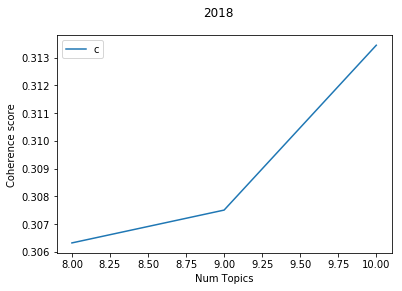

In [14]:
limit=11; start=8; step=1;
x = range(start, limit, step)
plt.figure().suptitle('2018')
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Select the 3 optimal models
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

In [ ]:
# # Show
x=0
for text in df_dominant_topic[df_dominant_topic['Dominant_Topic']==5.0]['Text']:
    print(text, '\n')
    x+=1
    if x>30:
        break

### Topic 2 and 5

In [ ]:
counts = {}
counts2 = {}
for text in sent_topics_sorteddf_mallet[(sent_topics_sorteddf_mallet['Dominant_Topic']==2.0) | (sent_topics_sorteddf_mallet['Dominant_Topic']==5.0)]['Text']:
    for token in text.strip().split():
        if token.startswith('#'):
            tag = strip_punc(token).lower()
            counts[tag] = counts.get(tag,0)+1
        if token.startswith('@'):
            tag = strip_punc(token).lower()
            counts2[tag] = counts2.get(tag,0)+1

In [ ]:
for tag in list(reversed(sorted(counts, key=counts.get)))[:30]:
    print(tag+':', counts[tag])
print()
for tag in list(reversed(sorted(counts2, key=counts2.get)))[:30]:
    print(tag+':', counts2[tag])

# Top handlers for each topic

In [ ]:
mapping = {
    'abcnews':'ABC News',
    'whiteribbonaust':'White Ribbon',
    'qanda': 'ABC Q&A',
    'thetodayshow':'The Today Show',
    'theage':'The Age',
    'acurrentaffair':'A Current Affair (marketplace)',
    'theprojecttv':'The Project (news)',
    'dvvic':'DV Vic',
    'smh':'Sydney Morning Herald',
    'dv':'Demostic Violence',
    'buzzrothfield':'Phil Rothfield (sports journalist)',
    'tonyabbottmhr': 'Tony Abbott',
    'charliepick':'Charlie Pickering (host)',
    'danielandrewsmp': 'Dan Andrews (MP)',
    'rosiebatty': 'Rosie Batty',
    'billshortenmp': 'Bill Shorten',
    'corybernardi':'Cory Bernardi (conservative)',
    'mariska': 'Mariska Hargitay (actress)',
    'mikebairdmp': 'Mike Baird (politician)',
    'colleenhartland': 'Colleen Hartland (MP)',
    'changeaus': 'Change.org',
    'dailylifeau': 'Daily Life',
    'conversationedu': 'The Conversation (news analysis)',
    'familycourtau':'Family Court',
    'womensagenda':"Women's Agenda (news)",
    'turnbullmalcolm': 'Malcolm Turnbull',
    'annastaciamp': 'Annastacia Palaszczuk (MP)',
    'johnmcaldwell': 'John Caldwell (reporter)',
    'lizbroderick':'Elizabeth Broderick (activist)',
    'frichardsonmp': 'Fiona Richardson (MP)',
    'erin': 'Erin Caton (activist)',
    'vanbadham': 'Van Badham (commentator)',
    'kate': 'Kate (artist)',
    'carringtonkl': 'Kerry Carrington (professor)',
    'skinnergj':"Dougy's Daily Digest",
    'newscomauhq':'news.com.au',
    'youtube': 'Youtube',
    'bairdjulia':'Dr Julia Baird (journalist)',
    'paulinehansonoz':'Pauline Hanson (politician)',
    'lyleshelton':'Lyle Shelton (lobbyist)',
    'mirandadevine':'Miranda Devine (columnist)',
    'senatorcash':'Michaelia Cash (minister)',
    'skynewsaust':'Sky News',
    'nrl':'National Rugby League',
    'ourwatchaus':'Our Watch',
    'realmarklatham':'Mark Latham (politician)',
    'nathutchins':'Natalie Hutchins (politician)',
    'peterdutton':'Peter Dutton (MP)',
    'perkinsmiki':'Miki Perkins (editor)',
    'canberratimes':'Canberra Times',
    'dancingceo': 'Dancing CEO (lifestyle)',
    'scottmorrisonmp': 'Scott Morrison',
    'hpu': "Hawaii Pacific Univ."
}

In [ ]:
handler_counts_each_topic = [{},{},{},{},{},{},{},{}]
for _, row in sent_topics_sorteddf_mallet.iterrows():
    topic_idx = int(row['Dominant_Topic'])
    dic = handler_counts_each_topic[topic_idx]
    text = data[indices[int(row['Document_No'])]]

    for token in text.split(' '):
        if token.startswith('@'):
            token += '/'
            i = 1
            while token[i].isalpha():
                i += 1
            if i > 1:
                handler = token[0:i].lower()
                dic[handler] = dic.get(handler, 0) + 1

In [ ]:
len(handler_counts_each_topic)

In [ ]:
influencers_df = pd.read_csv('middle-data/influencers-5.csv')
influencers_df.drop('Unnamed: 0', axis=1, inplace=True)
influencers_df.head()

In [ ]:
table = []
x = 2016
table.append(['topic_idx','influencer_idx','count','topic','influencer'])
df = influencers_df[influencers_df['year']==x]
for i in range(8):
    for ii, row in df.iterrows():
        if row['handler'] in handler_counts_each_topic[i]:
            count = handler_counts_each_topic[i][row['handler']]
            table.append([i, 9-ii+(x-2014)*10, count, topic_names[i], row['name']])
            
table

In [ ]:
df

In [ ]:
pd.DataFrame(table[1:], columns=table[0]).to_csv('output/topic_influencer/2016.csv', index=False)

## Most dominant topics and number of documents for each:

In [ ]:
# Number of Documents for Each Topic
series_topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

idx = []
topic_counts = []
keywords = []
topic_contributions = []

for (i, count) in series_topic_counts.iteritems():
    idx.append(int(i))
    keywords.append(", ".join([word for word, _ in optimal_model.show_topic(int(i))]))
    topic_counts.append(count)
    topic_contributions.append(str(round(100*count/series_topic_counts.sum(), 2))+'%')
    
df_dominant_topics = pd.DataFrame.from_dict({
    'Dominant_Topic_Num': idx,
    'Topic_Keywords': keywords, 
    'Num_Documents': topic_counts, 
    'Perc_Documents': topic_contributions
})

# Show
pd.options.display.max_colwidth = 100
df_dominant_topics.set_index('Dominant_Topic_Num', inplace=True)
df_dominant_topics

# DF to Excel

In [ ]:
from pandas import ExcelWriter

writer = ExcelWriter('output/2014/data/2014_13_clusters.xlsx')
new_df = df_dominant_topics.copy()
new_df.index += 1
new_df.to_excel(writer,'topic_rank')

for topic_no in range(13):
    new_df = sent_topics_sorteddf_mallet.iloc[topic_no*40:((topic_no+1)*40),[0,4]]
    new_df.set_index('Document_No', inplace=True)
    
    replied_texts = []
    for i, row in new_df.iterrows():
        if replied_ids[indices[i]]:
            try:
                text = api.get_status(replied_ids[indices[i]], tweet_mode='extended').full_text
                replied_texts.append(text)
            except:
                replied_texts.append('')
        else:
            replied_texts.append('')
            
    new_df['In_Reply_To'] = replied_texts
    
    new_df.reset_index(inplace=True)
    new_df.drop(['Document_No'], axis=1, inplace=True)
    new_df.to_excel(writer,'topic_'+str(topic_no+1))
    
writer.save()

# Evaluation

In [ ]:
pyLDAvis.enable_notebook()
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model_list[0])
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

In [ ]:
pyLDAvis.save_html(vis, 'output/2014/visually_aided_clusters/2014_13_clusters.html')

# TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer 

In [ ]:
stop_words = [strip_punc(w) for w in stopwords.words('english')]
stop_words.extend([
    'i',
    'u',
    'r',
    'im',
    'cant',
    'would',
    'family',
    'domestic',
    'violence',
    'australia',
    'australian',
    'dv',
    'fv',
    'au',
    'via',
    'today',
    'thing',
    'make',
    'talk',
    'due',
    'day',
    'month',
    'find',
    'show',
    'put',
    'part',
    'time',
    'yeah',
    'deal',
    'big',
    'level',
    'focus',
    'theyre',
    'list',
    'top',
    'give',
    'situation',
    'lot',
    'hold',
    'number',
    'include',
    'form',
    'back',
    'involve',
    'link',
    'real',
    'get',
    'go',
    'have',
    'do',
    'take',
    'time','year','month','week','day','say'
])


def clean_text(text):
    cleaned_text = ''
    for token in text.split():
        
        # Cleaning
        if token[0] in ['@','$','%','^','&','*'] or token.startswith('http'):
            continue

        # Remove puctuations, lower case
        token = strip_punc(token.lower())
        
        # Lemmatize
        lemma = lemmatize(token)

        if lemma and lemma not in stop_words:
            cleaned_text += lemma + ' '
    
    return cleaned_text.strip()

In [ ]:
docs = []
raw_docs = []
conn = sqlite3.connect('dpc.db')

df = pd.read_sql('SELECT text, [extended_tweet.full_text] FROM tweets', conn)
conn.close()

for i, row in df.iterrows():
    text = ''
    if row['extended_tweet.full_text']:
        text = clean_text(row['extended_tweet.full_text'])
        raw_docs.append(row['extended_tweet.full_text'])
    else:
        text = clean_text(row['text'])
        raw_docs.append(row['text'])
    docs.append(text)

print(len(docs), docs[0])

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True)

vector_space = vectorizer.fit_transform(docs)

In [ ]:
victim_docs = []
victim_raw_docs = []
for text in sent_topics_sorteddf_mallet[(sent_topics_sorteddf_mallet['Dominant_Topic']==2.0) | (sent_topics_sorteddf_mallet['Dominant_Topic']==5.0)]['Text']:
    victim_docs.append(clean_text(text))
    victim_raw_docs.append(text)

In [ ]:
vectors = vectorizer.transform(victim_docs)

In [ ]:
scores = []
for vector in vectors:
    scores.append(np.sum(vector))
scores[:5]

In [ ]:
arr = np.array(scores)
indices = (-arr).argsort()[:40]
print(scores[indices[0]])

In [ ]:
for idx in indices:
    print(victim_raw_docs[idx], '\n')

In [ ]:
doc = ''
for text in sent_topics_sorteddf_mallet[(sent_topics_sorteddf_mallet['Dominant_Topic']==2.0) | (sent_topics_sorteddf_mallet['Dominant_Topic']==5.0)]['Text']:
    doc += clean_text(text) + ' '
doc = doc.strip()    

df = pd.DataFrame(vectorizer.transform([doc]).T.todense(), index=vectorizer.get_feature_names(), columns=["tfidf"])
print(df.sort_values(by=["tfidf"],ascending=False))

In [ ]:
scores = {}
x = 0
for text in victim_docs:
    tokens = text.split()
    for i in range(len(tokens)-1):
        scores[(tokens[i], tokens[i+1])] = scores.get((tokens[i], tokens[i+1]),0)+1

#     x += 1
#     if x % 100 == 0:
#         print(x, end=' ')

In [ ]:
for w in list(sorted(scores, key=scores.get, reverse=True))[:40]:
    print(str(w)+':', scores[w])

In [ ]:
len(victim_docs)

In [ ]:
conn = sqlite3.connect('dpc.db')

df = pd.read_sql('SELECT count(*) FROM tweets where created_at like "%2017"', conn)
conn.close()

df